In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi
from gala.dynamics import mockstream as ms

import pickle

from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline

ham = gp.Hamiltonian(gp.MilkyWayPotential())

coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [2]:
plt.style.use('notebook')

In [3]:
fr = pickle.load(open('../data/ylgr_frame.pkl', 'rb'))

In [4]:
fr.pole, fr.rotation

(<ICRS Coordinate: (ra, dec, distance) in (deg, deg, )
     (73.82617395, -22.94518097, 1.)>,
 <Quantity 63. deg>)

## Analyze Gaia data

In [5]:
t = Table(fits.getdata('../data/ylgr_combined_sfd.fits.gz'))

In [6]:
dist_dyn = 8.5*u.kpc
arr_dist = np.ones(len(t)) * dist_dyn

# correct for solar reflex motion
ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(fr)

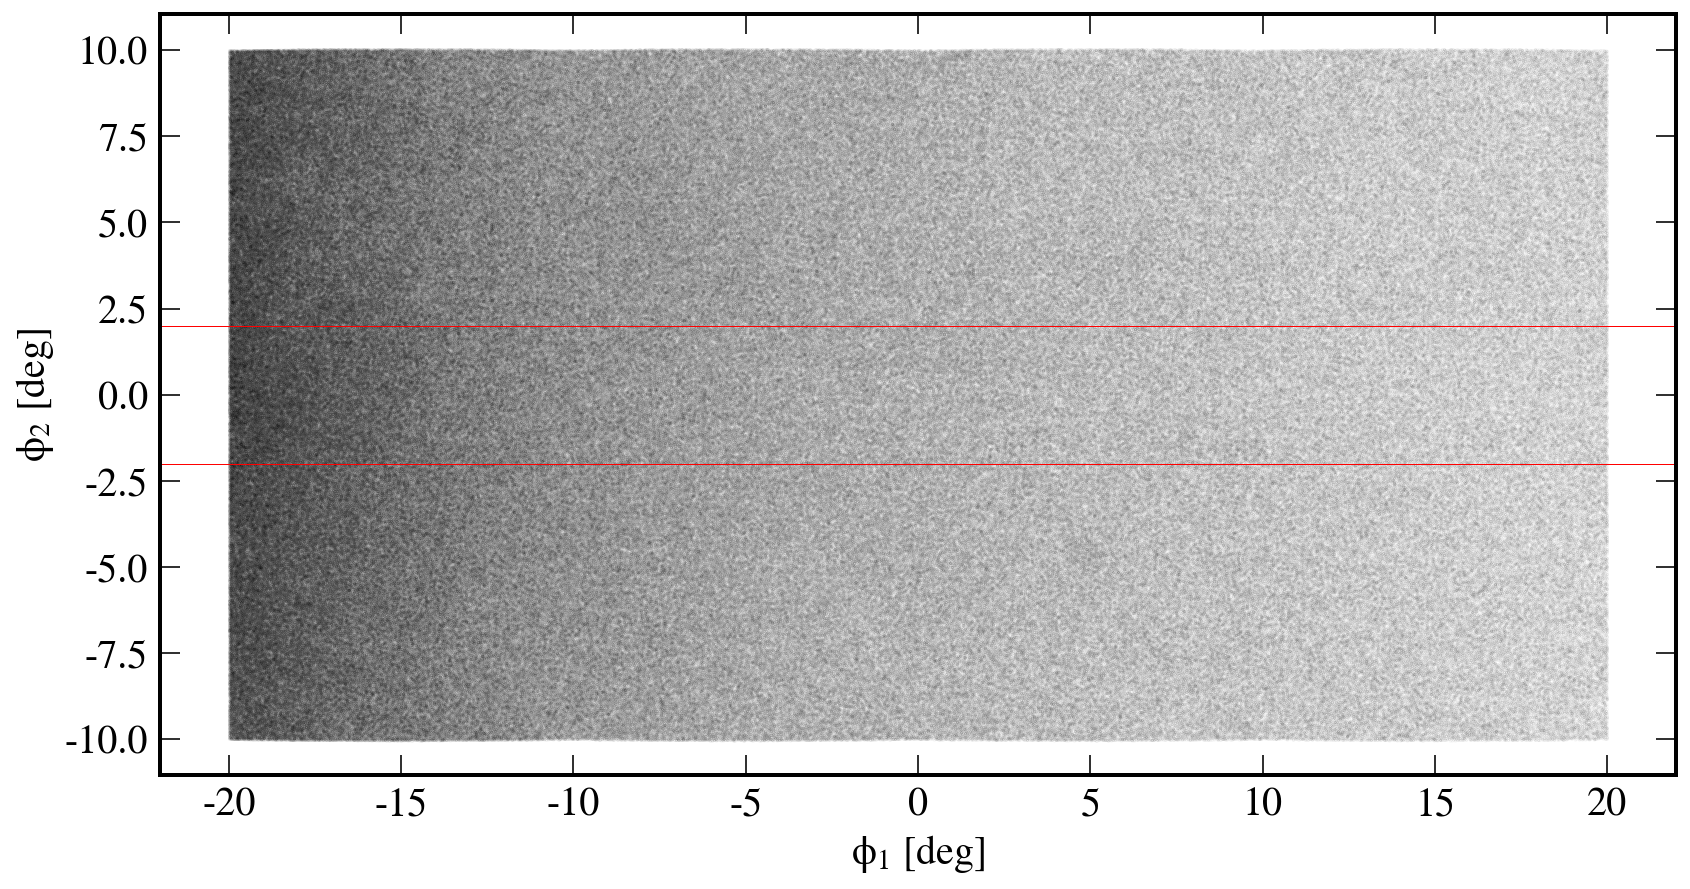

In [7]:
plt.figure(figsize=(15,7))
plt.plot(c.phi1, c.phi2, 'k.', ms=0.2, alpha=0.1)

c_gc = coord.SkyCoord(phi1=7.8*u.deg, phi2=-1.9*u.deg,frame=fr)

plt.axhline(-2, color='r', lw=0.5)
plt.axhline(2, color='r', lw=0.5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.gca().set_aspect('equal')

In [8]:
cg = c.transform_to(coord.Galactic)

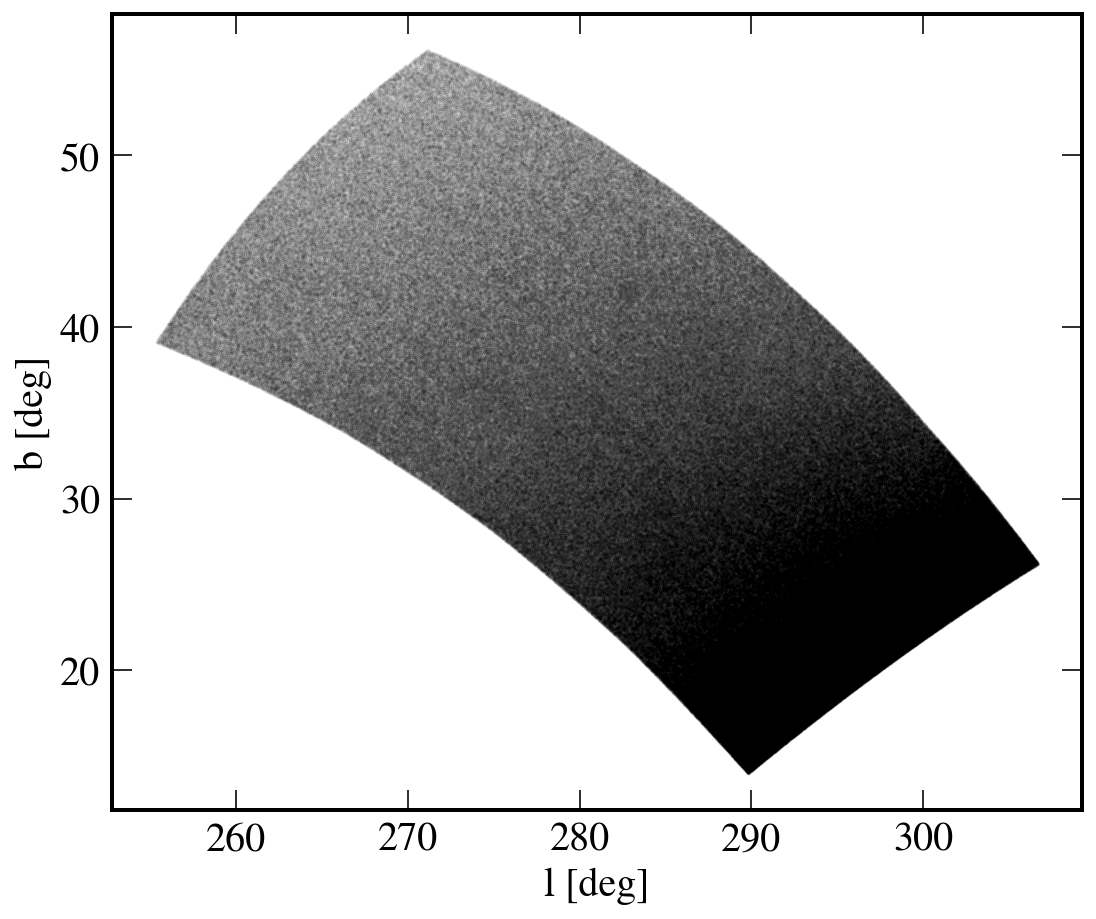

In [9]:
plt.plot(cg.l, cg.b, 'k.', ms=0.2, alpha=0.1)

plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.gca().set_aspect('equal')
plt.tight_layout()

## Preliminary membership

In [10]:
# spatial selections
ind_phi2 = (np.abs(c.phi2)<2*u.deg) & (np.abs(c.phi1)<15*u.deg)
ind_off = (np.abs(c.phi2)<6*u.deg) & (np.abs(c.phi2)>4*u.deg) & (np.abs(c.phi1)<15*u.deg)

# approximate proper motion selection from literature
ind_pmeq = (t['pmra']>-2) & (t['pmra']<1) & (t['pmdec']>-8) & (t['pmdec']<-5.5)

In [11]:
# for cmd filtering using matplotlib polygons
points = np.array([t['bp_rp0'], t['g0']]).T

In [12]:
# distance modulus
dist_phot = 9.5*u.kpc
dm = 5*np.log10((dist_phot.to(u.pc)).value)-5

# read isochrone
iso_full = Table.read('../data/mist_13.0_-2.00.cmd',
                 format='ascii.commented_header', header_start=12)
phasecut = (iso_full['phase']>=0) & (iso_full['phase']<4)
iso = iso_full[phasecut]
i_bprp_ = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
i_g_ = iso['Gaia_G_EDR3']+dm

# main sequence + rgb
i_bprp = iso['Gaia_BP_EDR3']-iso['Gaia_RP_EDR3']
i_g = iso['Gaia_G_EDR3']+dm

In [13]:
# MS + RGB selection
i_left = i_bprp - 0.15*(i_g/28)**2
i_right = i_bprp + 0.2*(i_g/28)**2

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21) & (poly[:,1]>12)
poly_main = poly[ind]

path_main = mpl.path.Path(poly_main)
ind_cmd = path_main.contains_points(points)

In [14]:
# BHB selection
g_min = 15.2
g_max = 15.7
bprp_min = -0.1
bprp_max = 0.2

poly_bhb = np.array([[bprp_min, g_max], [bprp_min, g_min], [bprp_max, g_min], [bprp_max, g_max]])
path_bhb = mpl.path.Path(poly_bhb)
ind_bhb = path_bhb.contains_points(points)

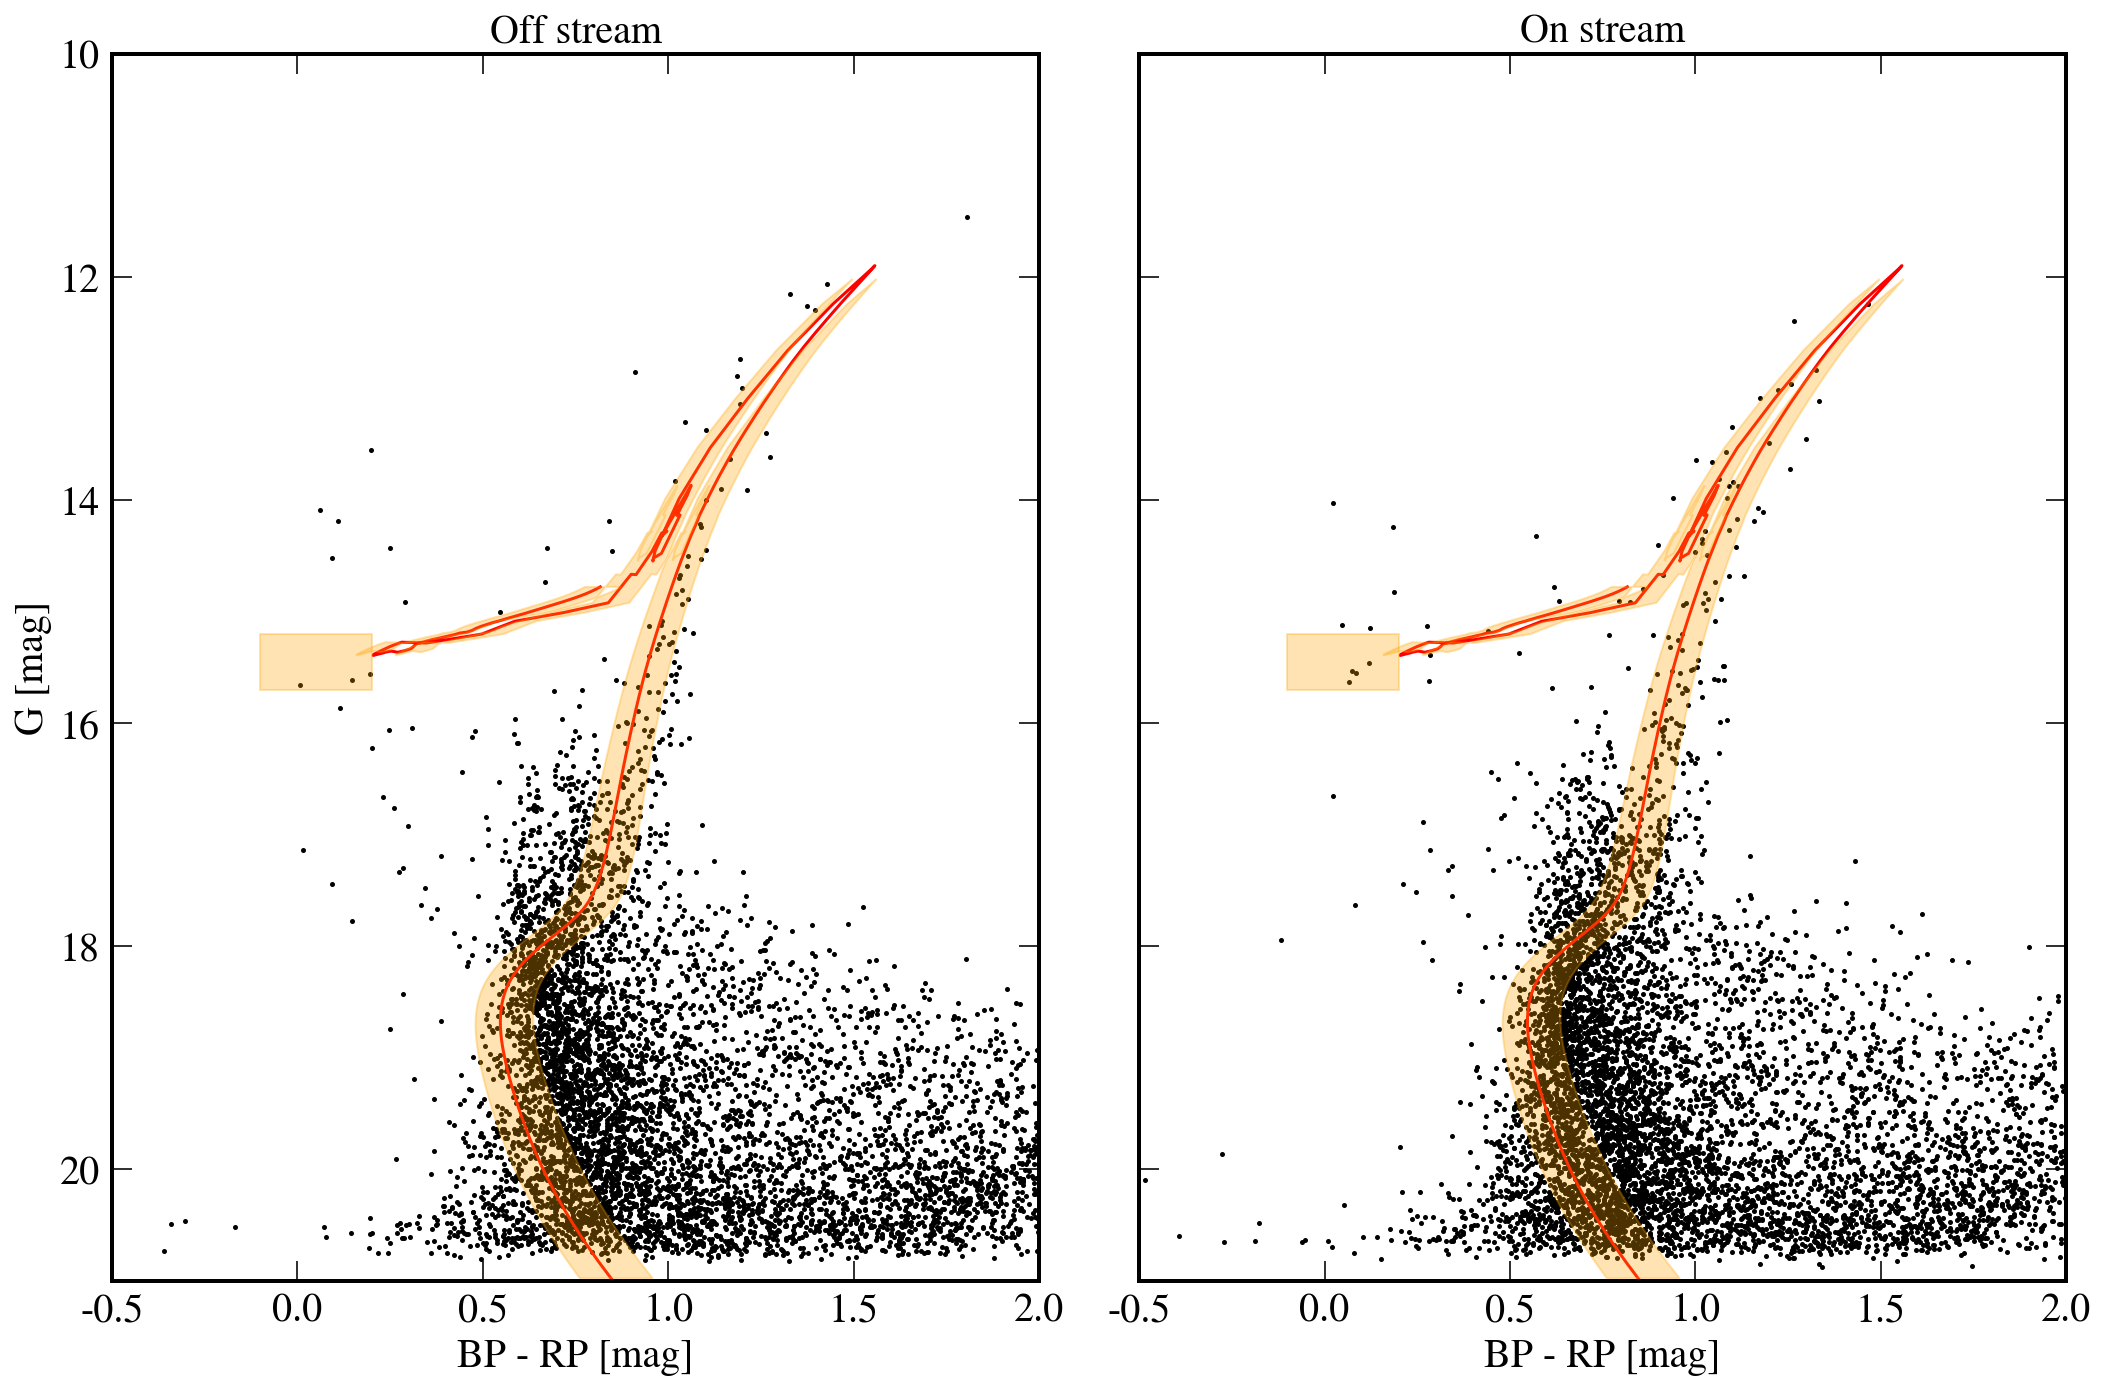

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,10), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(t['bp_rp0'][ind_off & ind_pmeq], t['g0'][ind_off & ind_pmeq], 'k.', ms=3, alpha=1)
plt.plot(i_bprp_, i_g_, 'r-')

plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.title('Off stream', fontsize='medium')
plt.xlim(-0.5,2)
plt.ylim(21,10)

plt.sca(ax[1])
plt.plot(t['bp_rp0'][ind_phi2 & ind_pmeq], t['g0'][ind_phi2 & ind_pmeq], 'k.', ms=3, alpha=1)
# plt.plot(t['bp_rp0'][ind_h3], t['g0'][ind_h3], **vr_dict)
# plt.plot(t['bp_rp0'][ind_seg], t['g0'][ind_seg], **vr2_dict)
plt.plot(i_bprp_, i_g_, 'r-')

plt.xlabel('BP - RP [mag]')
plt.title('On stream', fontsize='medium')

for e in range(2):
    plt.sca(ax[e])
    pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pm)

    pm = mpl.patches.Polygon(poly_bhb, color='orange', alpha=0.3, zorder=2, label='')
    plt.gca().add_artist(pm)

plt.tight_layout()
plt.savefig('../plots/cmd.png')

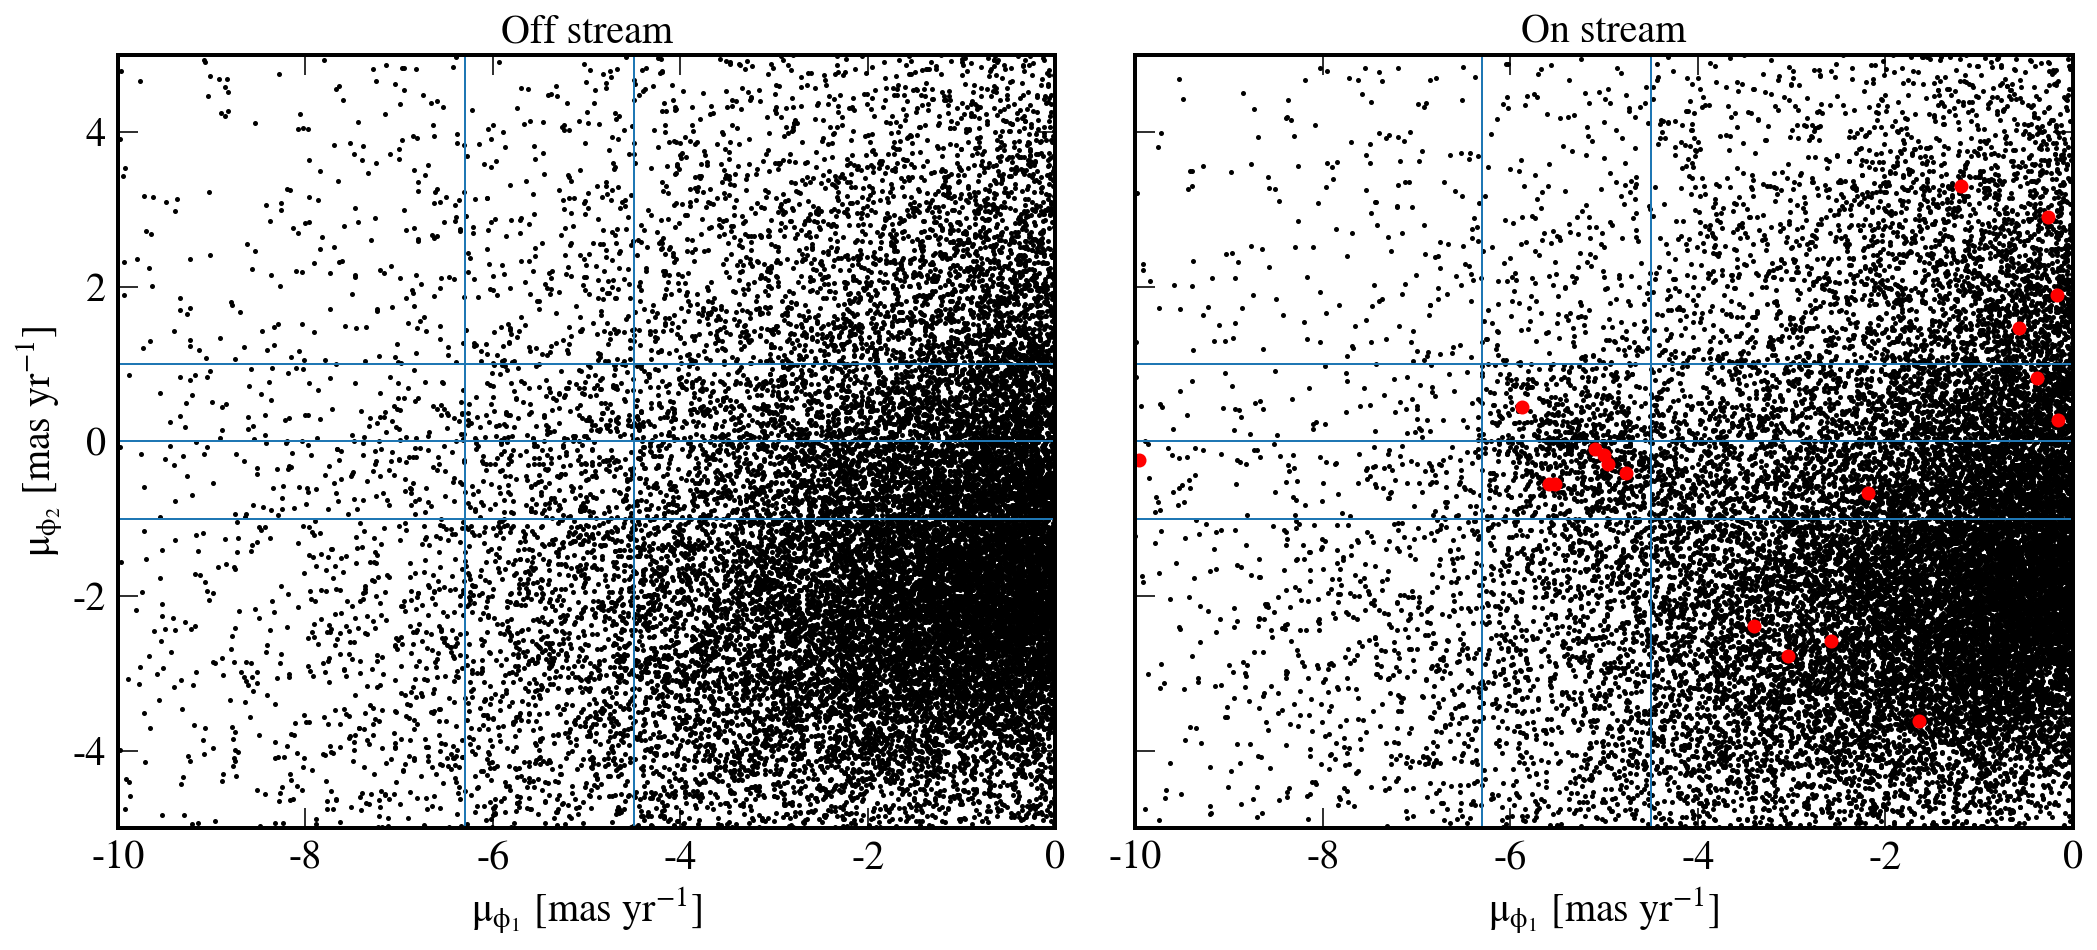

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,7), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(c.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_off], c.pm_phi2[(ind_bhb | ind_cmd) & ind_off],
         'k.', ms=3, alpha=1)

plt.xlim(-10,0)
plt.ylim(-5,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(c.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_phi2], c.pm_phi2[(ind_bhb | ind_cmd) & ind_phi2],
         'k.', ms=3, alpha=1)
plt.plot(c.pm_phi1_cosphi2[ind_bhb & ind_phi2], c.pm_phi2[ind_bhb & ind_phi2], 'ro')

plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.title('On stream', fontsize='medium')

lw = 1

for e in range(2):
    plt.sca(ax[e])
    plt.axhline(0, lw=lw)

    plt.axvline(-6.3, lw=lw)
    plt.axvline(-4.5, lw=lw)
    plt.axhline(-1, lw=lw)
    plt.axhline(1, lw=lw)


plt.tight_layout()
plt.savefig('../plots/pmphi.png')

### Select BHBs

In [17]:
ind_pm_bhb = ((c.pm_phi1_cosphi2>-6.3*u.mas/u.yr) & (c.pm_phi1_cosphi2<-4.5*u.mas/u.yr) & (c.pm_phi2>-1*u.mas/u.yr)
          & (c.pm_phi2<1*u.mas/u.yr))

In [18]:
np.sum(ind_bhb & ind_pm_bhb & ind_phi2)

7

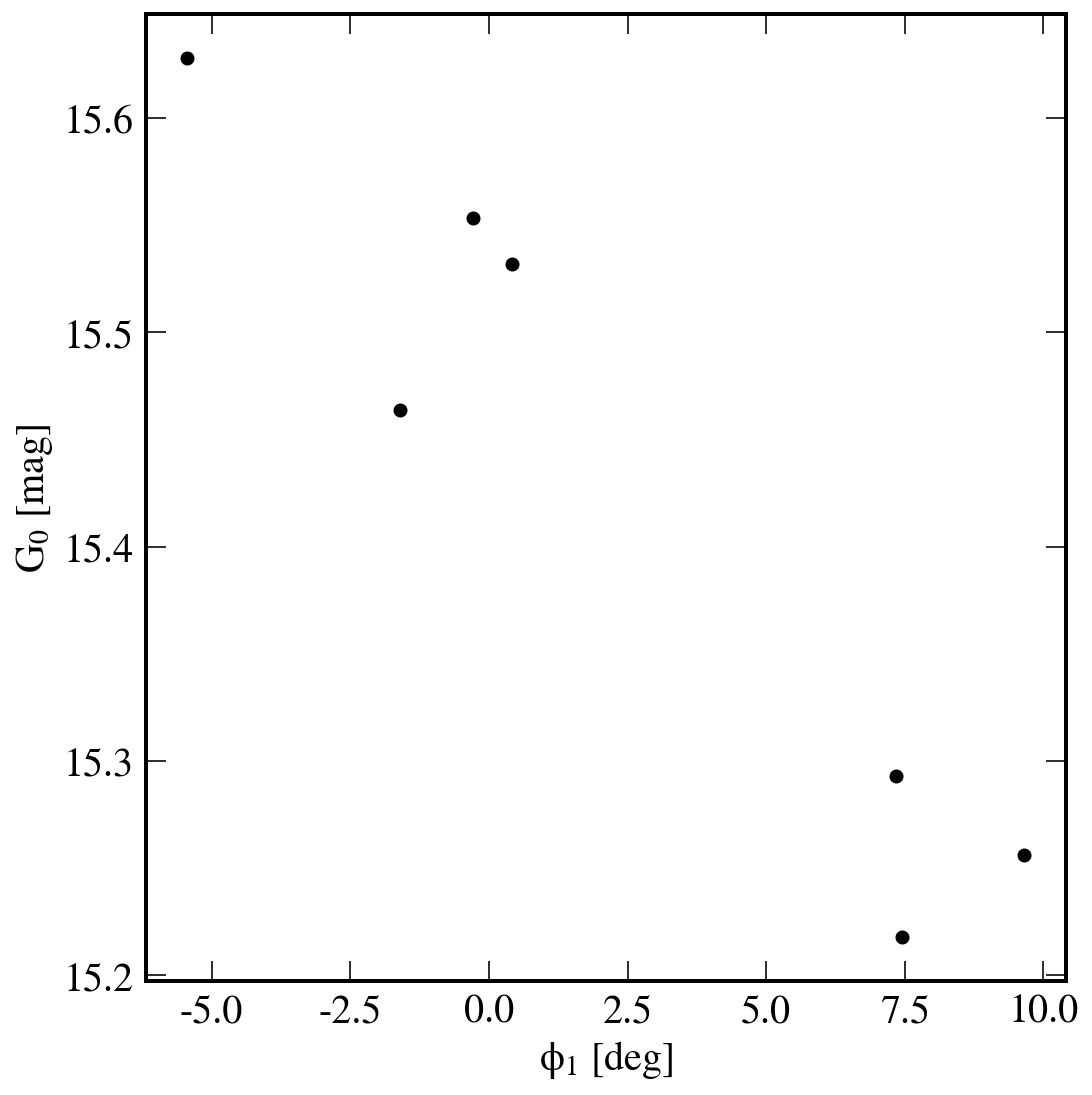

In [19]:
plt.plot(c.phi1[ind_bhb & ind_pm_bhb & ind_phi2], t['g0'][ind_bhb & ind_pm_bhb & ind_phi2], 'ko')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$G_0$ [mag]')
plt.tight_layout()

In [20]:
ind_mem_bhb = ind_bhb & ind_pm_bhb & ind_phi2

In [21]:
pbhb = np.load('../data/bhb_mg.npy')
mg_bhb = np.poly1d(pbhb)

mu = t['g0'][ind_mem_bhb] - mg_bhb(t['bp_rp0'][ind_mem_bhb])
d = (10**(0.2*mu + 1)*u.pc).to(u.kpc)
print(mu, d)

        g0        
------------------
14.778031964880578
14.757344376382648
14.810993660223216
14.507113670946298
14.506257757294096
14.476938633749368
14.735139222219466 [9.02830855 8.9427044  9.16639846 7.96934694 7.96620634 7.85936985
 8.8517236 ] kpc


In [22]:
t['parallax'][ind_mem_bhb]**-1

<Column name='parallax' dtype='float64' length=7>
48.155881713446824
 9.840815349261655
14.124306866906727
-43.44953790932724
 21.01330779736868
 10.42347852639402
12.829168698309537

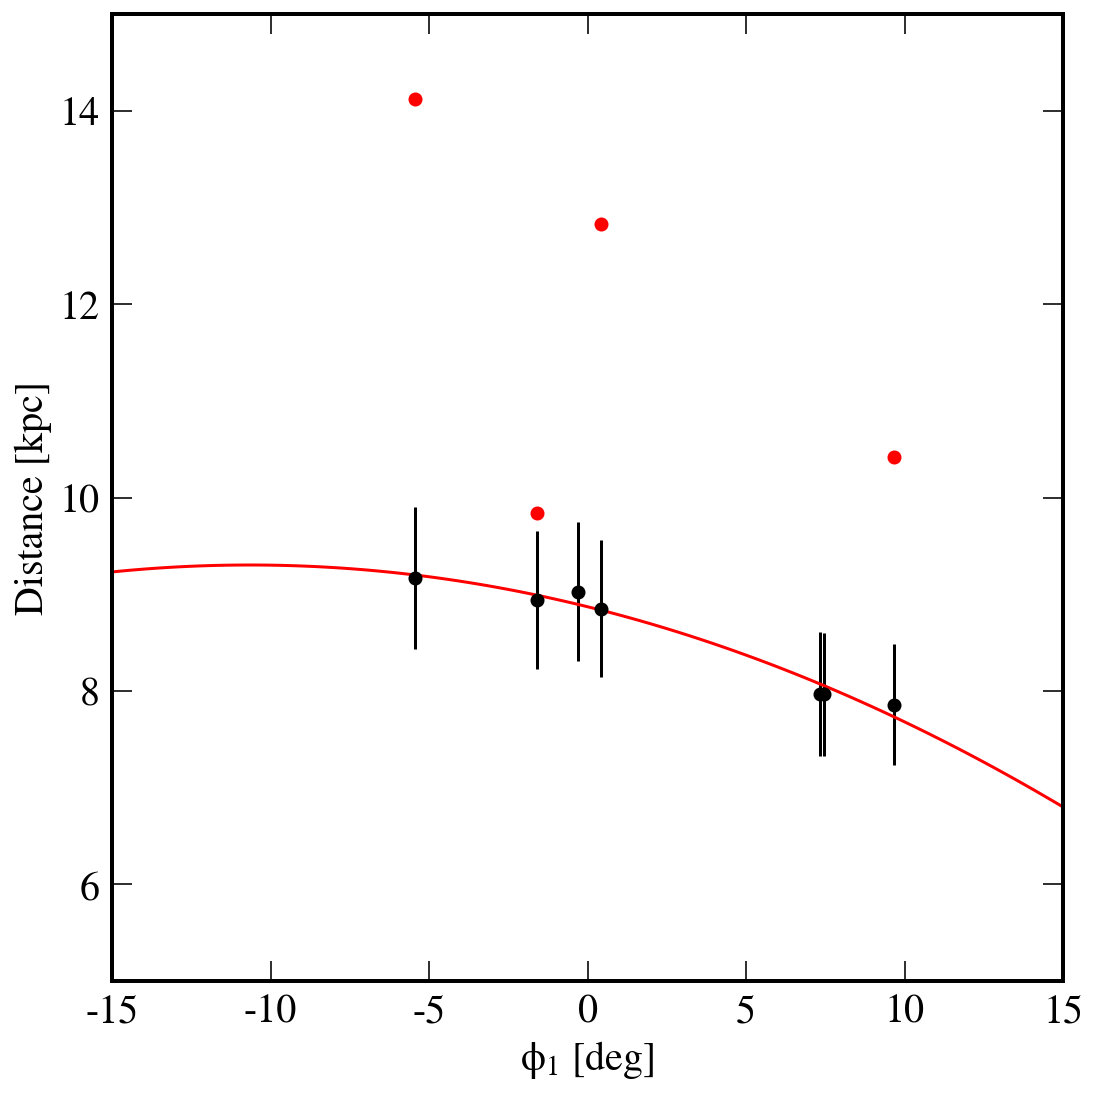

In [23]:
plt.plot(c.phi1[ind_mem_bhb], t['parallax'][ind_mem_bhb]**-1, 'ro')
plt.errorbar(c.phi1[ind_mem_bhb].value, d.value, yerr=0.08*d.value, fmt='o', color='k')

# fit distance gradient
kdist = 2
pdist = np.polyfit(c.phi1[ind_mem_bhb].value, d.value, kdist)
poly_dist = np.poly1d(pdist)

phi1_ = np.linspace(-15,15,100)
dist_ = poly_dist(phi1_)
plt.plot(phi1_, dist_, 'r-')

plt.xlim(-15,15)
plt.ylim(5,15)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('Distance [kpc]')
plt.tight_layout()

## Membership with BHB distance gradient

In [24]:
# new distances
arr_dist_dbhb = poly_dist(c.phi1.deg)*u.kpc

# updated reflex motion correction
ceq_nc_dbhb = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist_dbhb,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
c_nc_dbhb = ceq_nc_dbhb.transform_to(fr)
ceq_dbhb = gc.reflex_correct(ceq_nc_dbhb)
c_dbhb = ceq_dbhb.transform_to(fr)

In [25]:
# expectation from the discovery paper
ind_vr = (t['radial_velocity']>300) & (t['radial_velocity']<350)

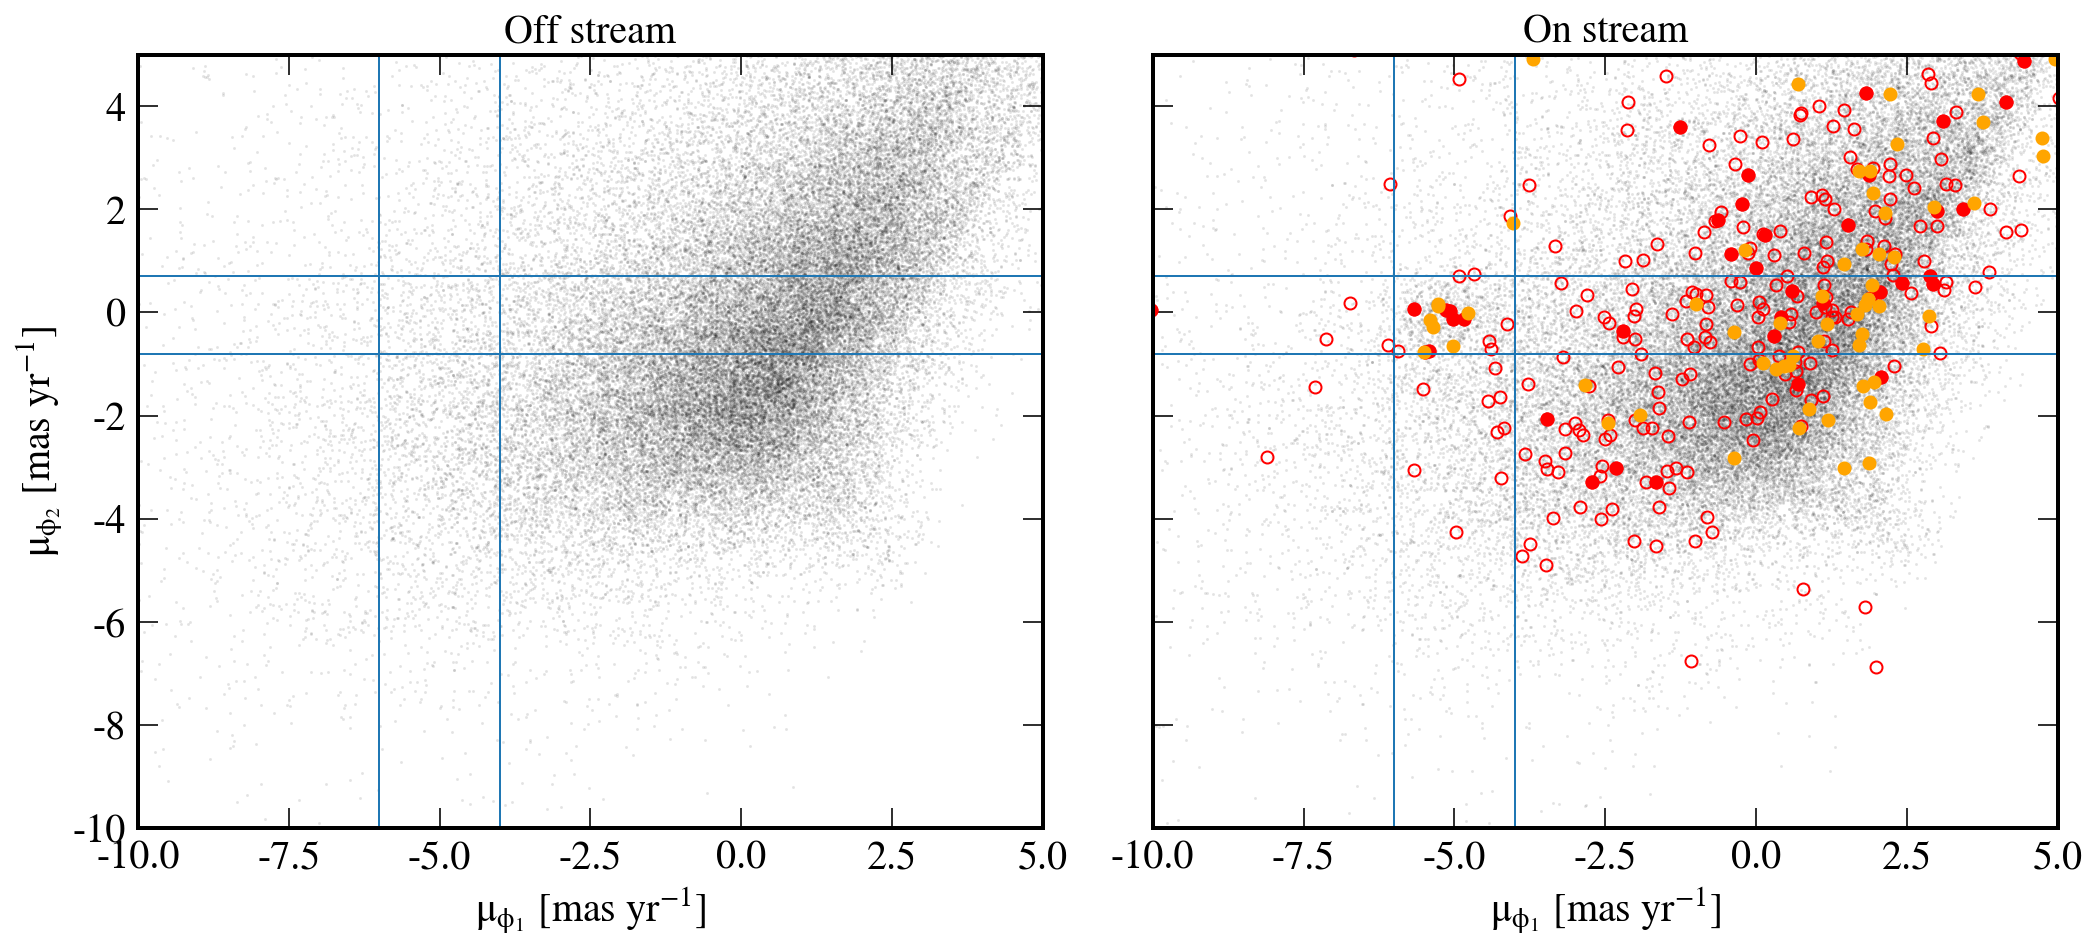

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,7), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(c_dbhb.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_off], c_dbhb.pm_phi2[(ind_bhb | ind_cmd) & ind_off],
         'k.', ms=1, alpha=0.1)

plt.xlim(-10,5)
plt.ylim(-10,5)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')

plt.sca(ax[1])
plt.plot(c_dbhb.pm_phi1_cosphi2[(ind_bhb | ind_cmd) & ind_phi2], c_dbhb.pm_phi2[(ind_bhb | ind_cmd) & ind_phi2],
         'k.', ms=1, alpha=0.1)
plt.plot(c_dbhb.pm_phi1_cosphi2[ind_bhb & ind_phi2], c_dbhb.pm_phi2[ind_bhb & ind_phi2], 'ro')
plt.plot(c_dbhb.pm_phi1_cosphi2[ind_bhb], c_dbhb.pm_phi2[ind_bhb], 'o', color='none', mec='r')
plt.plot(c_dbhb.pm_phi1_cosphi2[ind_vr & ind_phi2], c_dbhb.pm_phi2[ind_vr & ind_phi2], 'o', color='orange')

plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.title('On stream', fontsize='medium')

lw = 1

for e in range(2):
    plt.sca(ax[e])
    plt.axvline(-6., lw=lw)
    plt.axvline(-4., lw=lw)
    plt.axhline(-0.8, lw=lw)
    plt.axhline(0.7, lw=lw)

for e in range(2):
    plt.sca(ax[e])
    plt.axvline(-6., lw=lw)
    plt.axvline(-4., lw=lw)
    plt.axhline(-0.8, lw=lw)
    plt.axhline(0.7, lw=lw)


plt.tight_layout()
plt.savefig('../plots/ylgr_pmphi.png')

In [27]:
ind_pm = ((c_dbhb.pm_phi1_cosphi2>-6*u.mas/u.yr) & (c_dbhb.pm_phi1_cosphi2<-4.*u.mas/u.yr) &
          (c_dbhb.pm_phi2>-0.8*u.mas/u.yr) & (c_dbhb.pm_phi2<0.7*u.mas/u.yr)
         )
ind_pm2 = ((c_dbhb.pm_phi1_cosphi2>-3.5*u.mas/u.yr) & (c_dbhb.pm_phi1_cosphi2<-1.5*u.mas/u.yr) &
          (c_dbhb.pm_phi2>-3.5*u.mas/u.yr) & (c_dbhb.pm_phi2<-2*u.mas/u.yr)
         )

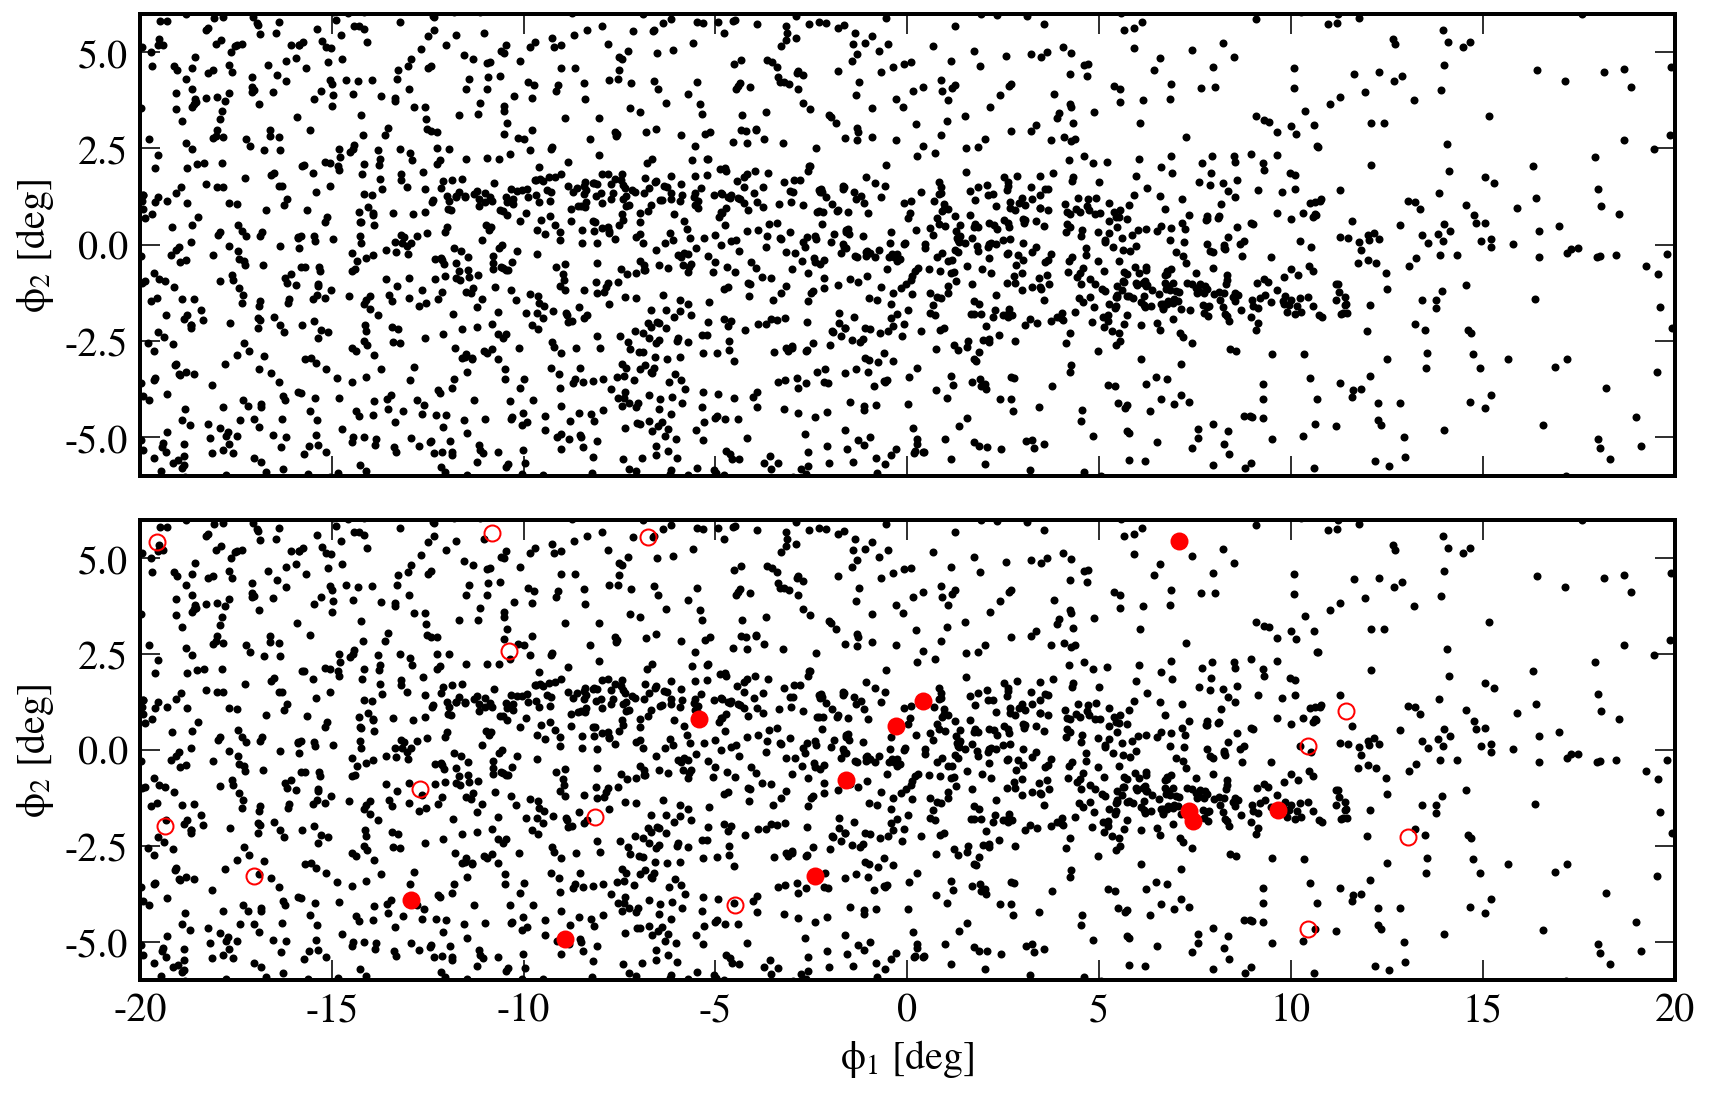

In [28]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
plt.sca(ax[0])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3)
plt.ylim(-6,6)
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3)
plt.plot(c_dbhb.phi1[ind_bhb & ind_pm], c_dbhb.phi2[ind_bhb & ind_pm], 'ro', ms=8)
plt.plot(c_dbhb.phi1[ind_bhb & ind_pm2], c_dbhb.phi2[ind_bhb & ind_pm2], 'o', mfc='none', mec='r', ms=8)

plt.ylim(-6,6)
plt.xlim(-20,20)
plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()
plt.savefig('../plots/ylgr_map.png')

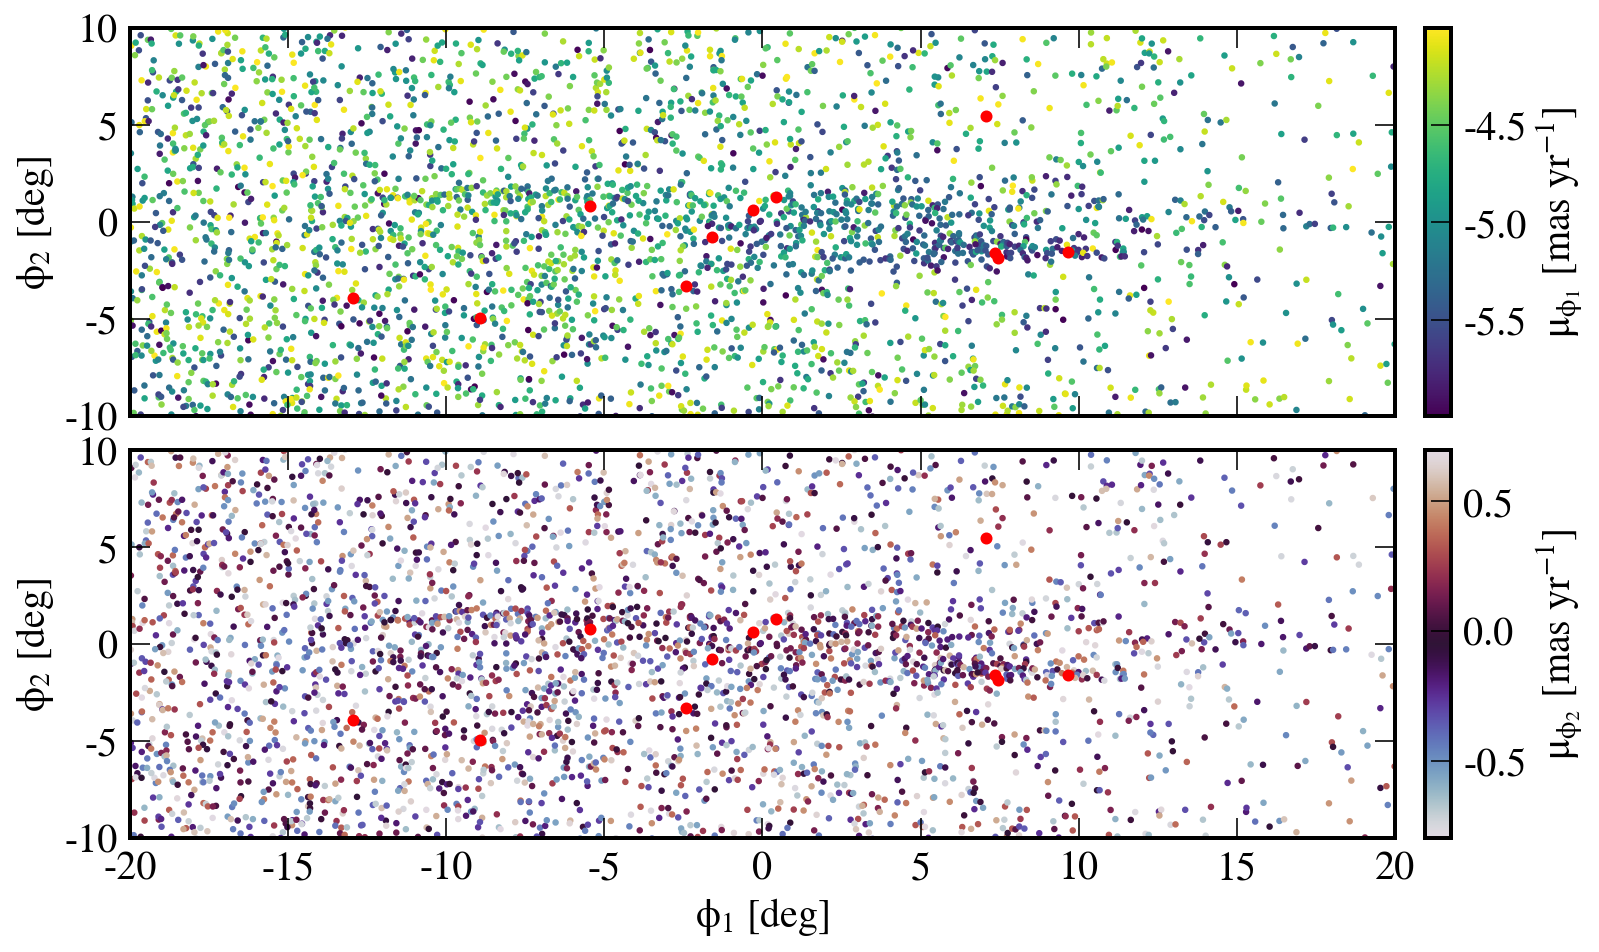

In [29]:
fig, ax = plt.subplots(2,1,figsize=(12,7), sharex=True, sharey=True)

plt.sca(ax[0])
im1 = plt.scatter(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm],
           c=c_dbhb.pm_phi1_cosphi2[ind_cmd & ind_pm], s=5, cmap='viridis')
plt.plot(c_dbhb.phi1[ind_bhb & ind_pm], c_dbhb.phi2[ind_bhb & ind_pm], 'ro', ms=5)
plt.ylabel('$\phi_2$ [deg]')
plt.colorbar(im1, label='$\mu_{\phi_1}$ [mas yr$^{-1}$]', pad=0.02, aspect=15)

plt.sca(ax[1])
im2 = plt.scatter(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm],
           c=c_dbhb.pm_phi2[ind_cmd & ind_pm], s=5, cmap='twilight')
plt.plot(c_dbhb.phi1[ind_bhb & ind_pm], c_dbhb.phi2[ind_bhb & ind_pm], 'ro', ms=5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-20,20)
plt.ylim(-10,10)
plt.colorbar(im2, label='$\mu_{\phi_2}$ [mas yr$^{-1}$]', pad=0.02, aspect=15)

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../plots/ylgr_colorby_pm.png')

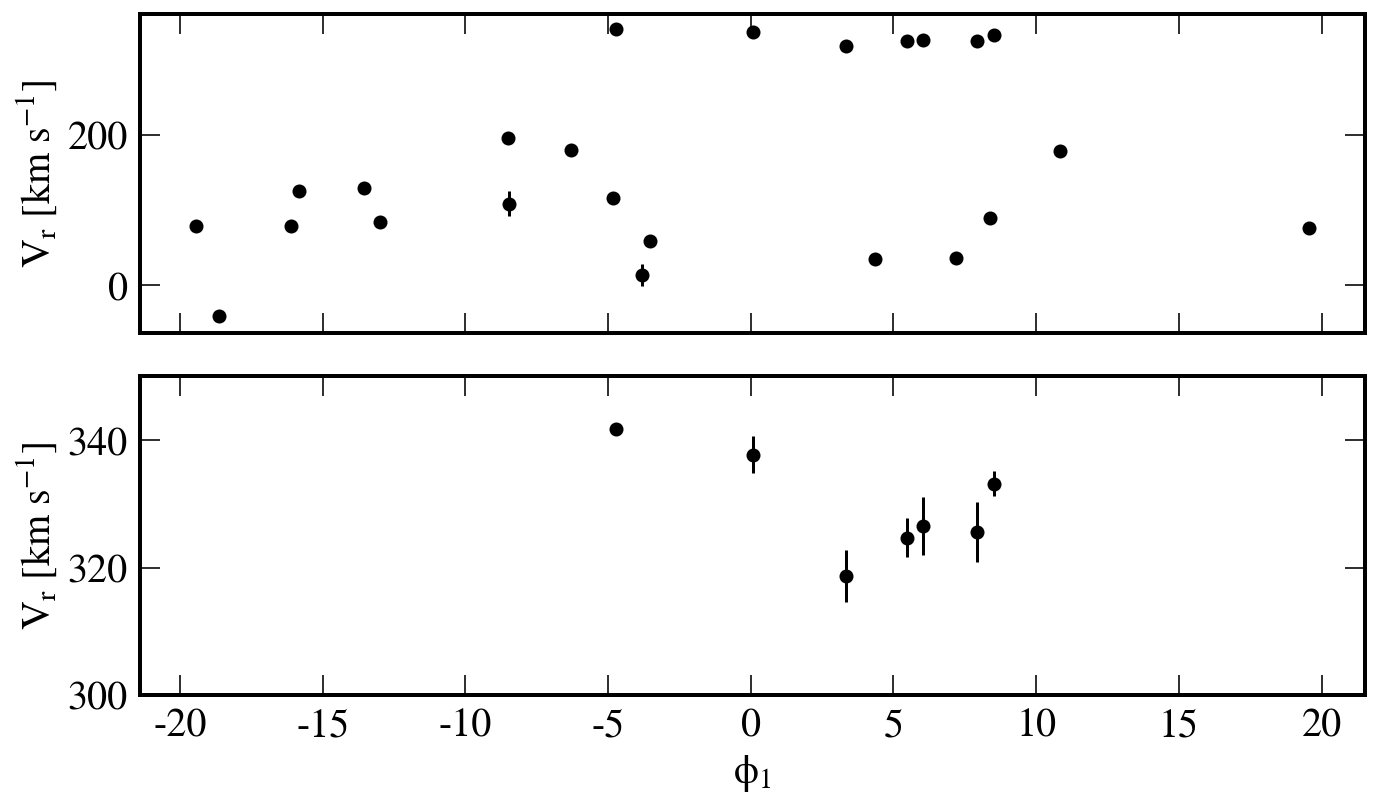

In [30]:
ind_phi2_wide = (np.abs(c.phi2)<2*u.deg) & (np.abs(c.phi1)<20*u.deg)
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)

for i in range(2):
    plt.sca(ax[i])
    plt.plot(c.phi1[ind_phi2_wide & ind_pm], t['radial_velocity'][ind_phi2_wide & ind_pm], 'ko')
    plt.errorbar(c.phi1[ind_phi2_wide & ind_pm], t['radial_velocity'][ind_phi2_wide & ind_pm], 
                 yerr=t['radial_velocity_error'][ind_phi2_wide & ind_pm], fmt='none', color='k')
    plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.xlabel('$\phi_1$')
plt.ylim(300,350)
plt.tight_layout()
plt.savefig('../plots/ylgr_vr.png')

In [31]:
np.sum(ind_vr & ind_phi2 & ind_pm)

7

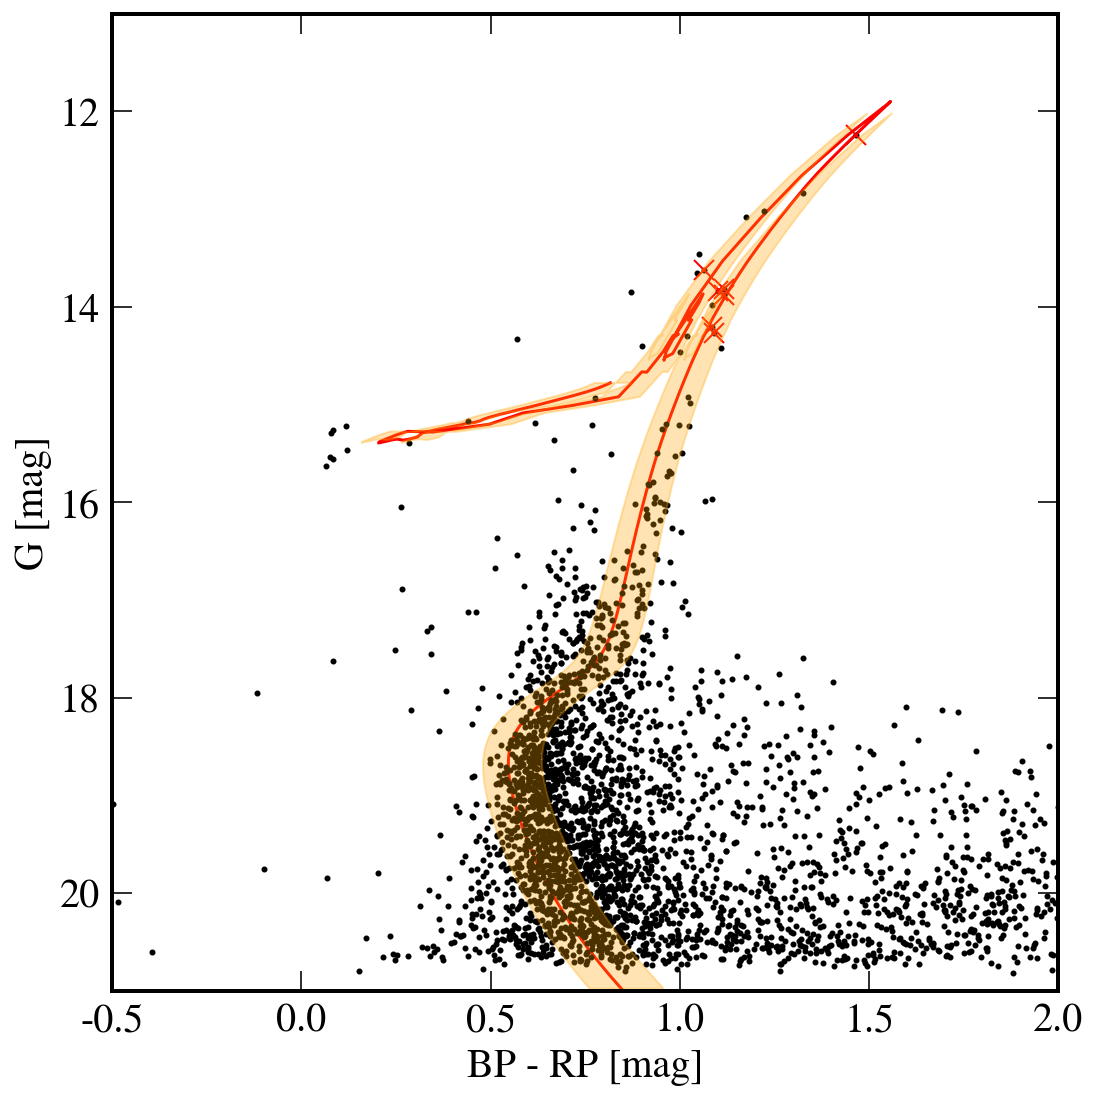

In [32]:
plt.plot(t['bp_rp0'][ind_phi2 & ind_pm], t['g0'][ind_phi2 & ind_pm], 'ko', ms=2, alpha=1)
plt.plot(t['bp_rp0'][ind_phi2 & ind_pm & ind_vr], t['g0'][ind_phi2 & ind_pm & ind_vr], 'rx', ms=10)
plt.plot(i_bprp_, i_g_, 'r-', zorder=0)
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)
    
plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.xlim(-0.5,2)
plt.ylim(21,11)

plt.tight_layout()

## Orbit fit

### Prepare members' dataset

In [33]:
# members for orbit fitting
ind_orbit = (ind_vr & ind_phi2 & ind_pm) | (ind_bhb & ind_phi2 & ind_pm)

In [34]:
np.sum(ind_orbit)

14

In [35]:
data = dict()

# stream track
phi2_err = np.std(c_dbhb.phi2[ind_cmd & ind_pm & ind_phi2])
data['phi2'] = [c_dbhb.phi1[ind_orbit], c_dbhb.phi2[ind_orbit], phi2_err]

# distance
# parallax-based
parallax_offset = -0.017 # Lindegren, Bastian, et al. (2021)
dp = (t['parallax'] + parallax_offset)**-1 * u.kpc
dp_err = dp / t['parallax_over_error']
ind_precise = ((dp_err/dp).decompose().value<0.15) & (dp>0*u.kpc)

# bhb-based
mu = t['g0'] - mg_bhb(t['bp_rp0'])
dbhb = (10**(0.2*mu + 1)*u.pc).to(u.kpc)
dbhb_err = 0.08 * dbhb

# combined distance
d = np.zeros(len(t)) * np.nan * u.kpc
d_err = np.zeros(len(t)) * np.nan * u.kpc
d[ind_bhb] = dbhb[ind_bhb]
d_err[ind_bhb] = dbhb_err[ind_bhb]
d[ind_precise] = dp[ind_precise]
d_err[ind_precise] = dp_err[ind_precise]

data['distance'] = [c_dbhb.phi1[ind_orbit], d[ind_orbit], d_err[ind_orbit]]

# proper motions
data['pm1'] = [c_dbhb.phi1[ind_orbit], c_nc_dbhb.pm_phi1_cosphi2[ind_orbit], t['pmra_error'][ind_orbit]*u.mas/u.yr]
data['pm2'] = [c_dbhb.phi1[ind_orbit], c_nc_dbhb.pm_phi2[ind_orbit], t['pmdec_error'][ind_orbit]*u.mas/u.yr]

# radial velocity
data['radial_velocity'] = [c_dbhb.phi1[ind_orbit], t['radial_velocity'][ind_orbit]*u.km/u.s, 
                 t['radial_velocity_error'][ind_orbit]*u.km/u.s]

# data dictionary without units (for inference)
data_nounits = dict()
for k in data.keys():
    data_nounits[k] = [x.value for x in data[k]]

/tmp/ipykernel_18449/1098770222.py:16: RuntimeWarning: overflow encountered in power
  dbhb = (10**(0.2*mu + 1)*u.pc).to(u.kpc)



In [36]:
pickle.dump(data_nounits, open('../data/ylgr_orbit_members.pkl', 'wb'))

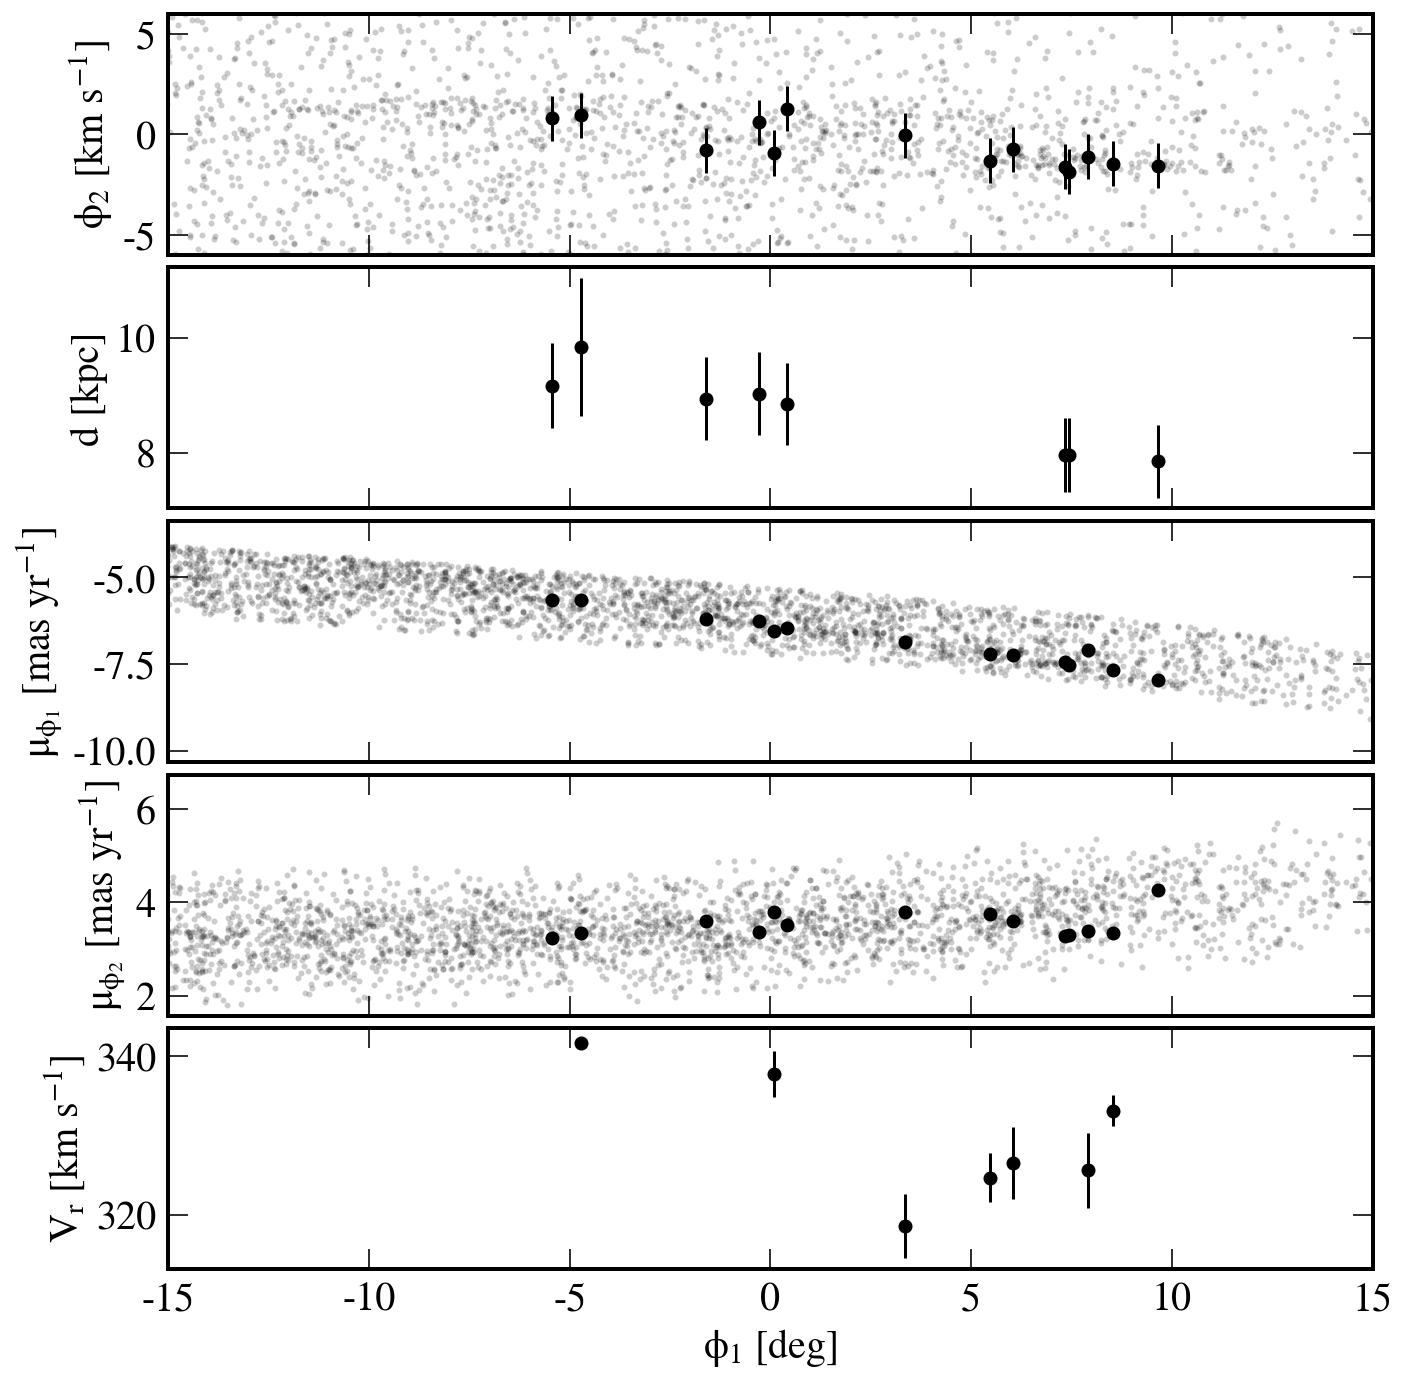

In [37]:
ylabels = ['$\phi_2$ [km s$^{-1}$]', 'd [kpc]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
          '$V_r$ [km s$^{-1}$]']

fig, ax = plt.subplots(5,1,figsize=(10,10), sharex=True)

for i, k in enumerate(data.keys()):
    plt.sca(ax[i])
    plt.errorbar(data[k][0], data[k][1], yerr=data[k][2], fmt='o', color='k')
    
    plt.ylabel(ylabels[i])
plt.xlim(-15,15)
plt.xlabel('$\phi_1$ [deg]')

plt.sca(ax[0])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)
plt.ylim(-6,6)

plt.sca(ax[2])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi1_cosphi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.sca(ax[3])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.tight_layout(h_pad=0)

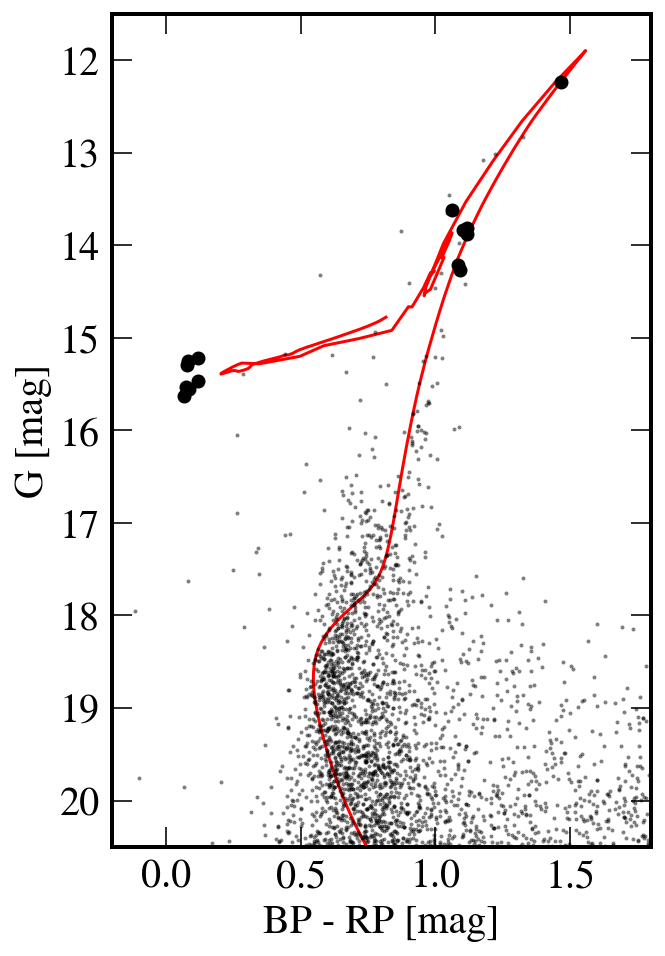

In [38]:
plt.figure(figsize=(5,7))
plt.plot(t['bp_rp0'][ind_orbit], t['g0'][ind_orbit], 'ko')
plt.plot(t['bp_rp0'][ind_pm & ind_phi2], t['g0'][ind_pm & ind_phi2], 'ko', mew=0, ms=2, alpha=0.5)

plt.plot(i_bprp_, i_g_, 'r-', zorder=0)

plt.xlabel('BP - RP [mag]')
plt.ylabel('G [mag]')
plt.xlim(-0.2,1.8)
plt.ylim(20.5,11.5)

plt.tight_layout()

### Fit orbit

In [39]:
def ln_likelihood(p, x_0, data, n_steps, dt, frame_pars):
    """"""
    # orbit parameters
    phi1 = x_0
    phi2, d, pm1, pm2, vr = p
    
    # priors
    if (d<0) | (np.abs(vr)>500) | (phi2<-90) | (phi2>90) | (phi1<-180) | (phi1>180):
        return -np.inf
    
    # orbit starting point
    frame = gc.GreatCircleICRSFrame(pole=frame_pars['pole'], rotation=frame_pars['rotation'])
    c = coord.SkyCoord(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, pm_phi1_cosphi2=pm1*u.mas/u.yr, 
                       pm_phi2=pm2*u.mas/u.yr, radial_velocity=vr*u.km/u.s, frame=frame)
    
    # integrate orbit
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
    
    # project stream coordinates
    model_stream = orbit.to_coord_frame(frame, galactocentric_frame=gc_frame)
    
    model_y = model_stream.phi2.to(u.deg).value
    model_dist = model_stream.distance.to(u.kpc).value
    model_pm1 = model_stream.pm_phi1_cosphi2.to(u.mas/u.yr).value
    model_pm2 = model_stream.pm_phi2.to(u.mas/u.yr).value
    model_vr = model_stream.radial_velocity.to(u.km/u.s).value

    # define interpolating functions
    model_x = model_stream.phi1.wrap_at(180*u.deg)
    bbox = [-180, 180]
    order = 3
    
    # sort
    ix = np.argsort(model_x)
    model_x = model_x[ix]
    
    # interpolate orbit onto data locations
    interp = {}
    interp['phi2'] = InterpolatedUnivariateSpline(model_x, model_y[ix], k=order, bbox=bbox)
    interp['distance'] = InterpolatedUnivariateSpline(model_x, model_dist[ix], k=order, bbox=bbox)
    interp['pm1'] = InterpolatedUnivariateSpline(model_x, model_pm1[ix], k=order, bbox=bbox)
    interp['pm2'] = InterpolatedUnivariateSpline(model_x, model_pm2[ix], k=order, bbox=bbox)
    interp['radial_velocity'] = InterpolatedUnivariateSpline(model_x, model_vr[ix], k=order, bbox=bbox)
    
    # model smoothing
    isigma = {}
    isigma['phi2'] = 0.01 # deg
    isigma['distance'] = 0.1 # kpc
    isigma['pm1'] = 0.7 # mas/yr
    isigma['pm2'] = 0.7 # mas/yr
    isigma['radial_velocity'] = 5 # km/s
    
    chi2 = 0
    keys = data.keys()
    for k in keys:
        sigma = np.sqrt(isigma[k]**2 + data[k][2]**2)
        chi2 += np.nansum(-(interp[k](data[k][0]) - data[k][1])**2 / sigma**2 - 2*np.log(sigma))
    
    return chi2

In [40]:
# trial parameters
x0 = 10
p0 = [-2,8,-8,4,310]
dt = 0.5*u.Myr
n_steps = 200

phi1 = x0
phi2, d, pm1, pm2, vr = p0
    
c = coord.SkyCoord(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, pm_phi1_cosphi2=pm1*u.mas/u.yr, 
                       pm_phi2=pm2*u.mas/u.yr, radial_velocity=vr*u.km/u.s, frame=fr)

# integrate orbit
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)

# project stream coordinates
model_stream = orbit.to_coord_frame(fr, galactocentric_frame=gc_frame)

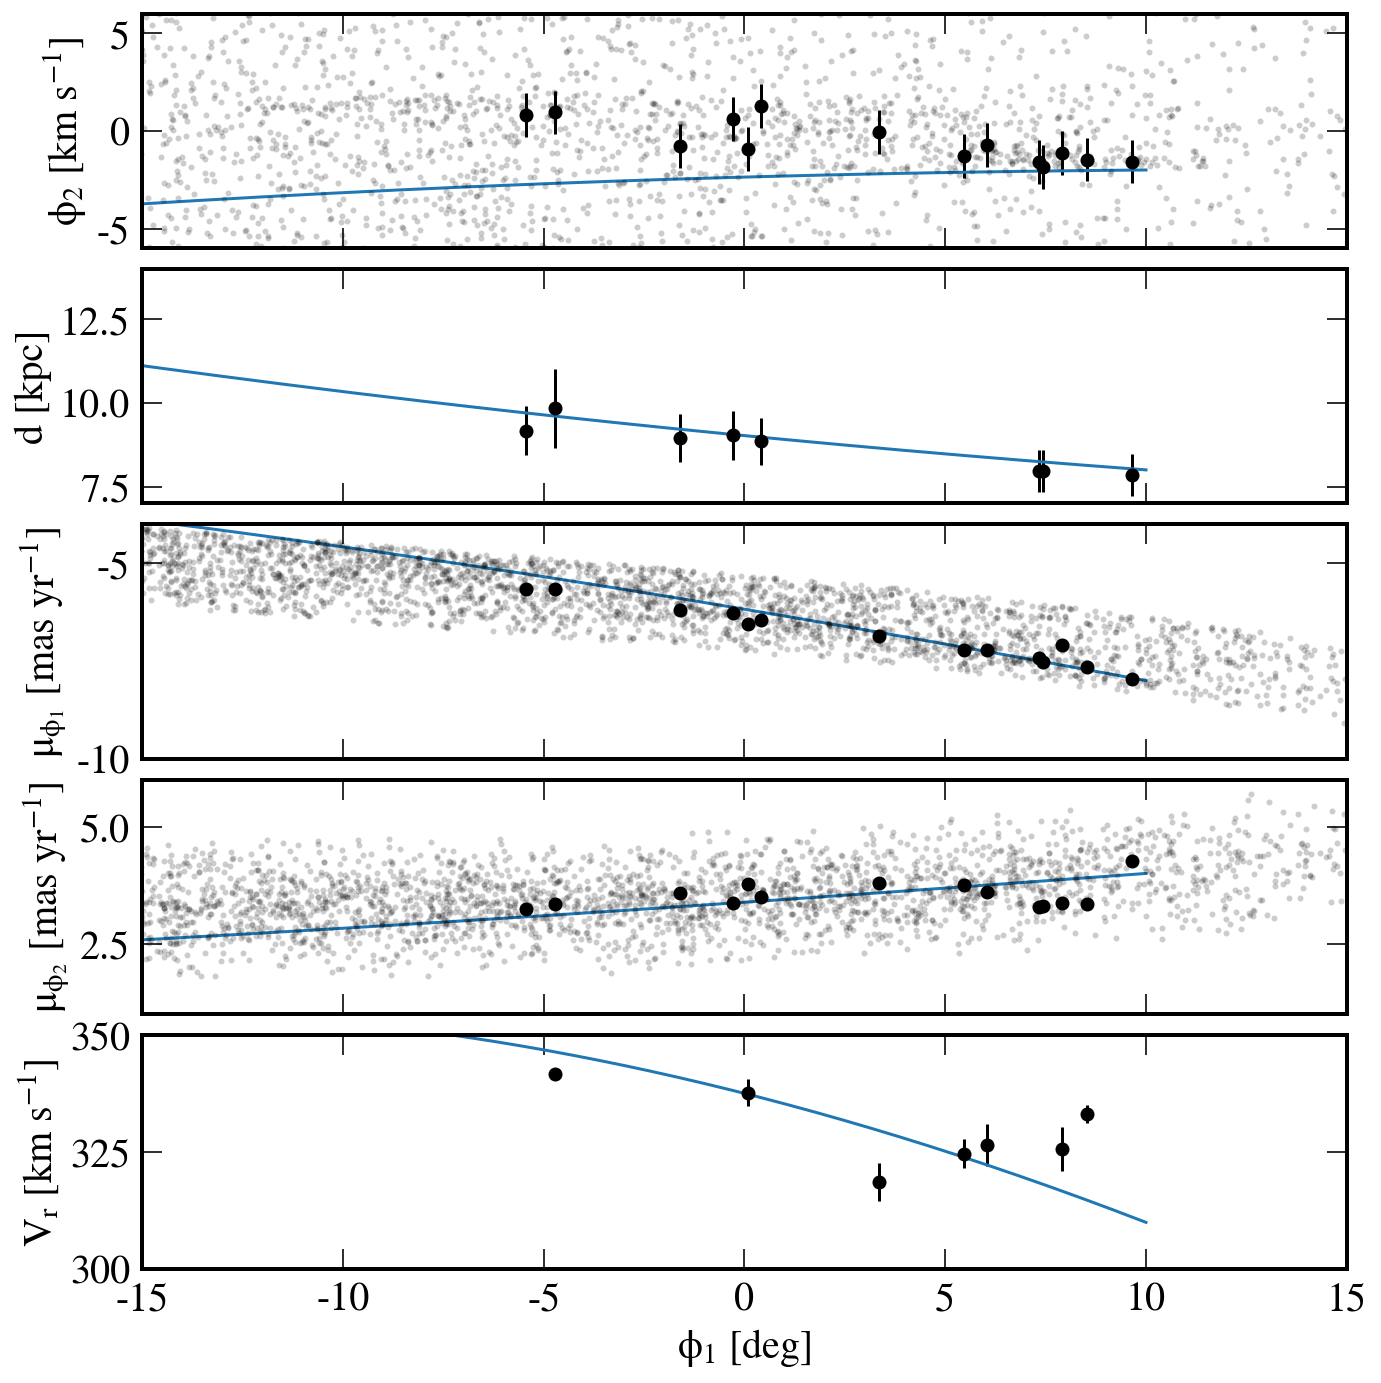

In [41]:
ylabels = ['$\phi_2$ [km s$^{-1}$]', 'd [kpc]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
          '$V_r$ [km s$^{-1}$]']

ylims = [[-6,6], [7,14], [-10,-4], [1,6], [300,350]]

ymodel = [model_stream.phi2, model_stream.distance, model_stream.pm_phi1_cosphi2, model_stream.pm_phi2,
         model_stream.radial_velocity]

fig, ax = plt.subplots(5,1,figsize=(10,10), sharex=True)

for i, k in enumerate(data.keys()):
    plt.sca(ax[i])
    plt.errorbar(data[k][0], data[k][1], yerr=data[k][2], fmt='o', color='k')
    plt.plot(model_stream.phi1, ymodel[i], '-')
    
    plt.ylabel(ylabels[i])
    plt.ylim(ylims[i])
plt.xlim(-15,15)
plt.xlabel('$\phi_1$ [deg]')

plt.sca(ax[0])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.sca(ax[2])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi1_cosphi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.sca(ax[3])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.tight_layout(h_pad=0)

In [42]:
# test likelihood
frame_pars = dict(pole=fr.pole, rotation=fr.rotation)
ln_likelihood(p0, x0, data_nounits, n_steps, dt, frame_pars)

-76.08115361026768

In [43]:
res = minimize(lambda *x: -ln_likelihood(*x), x0=p0, args=(x0, data_nounits, n_steps, dt, frame_pars))

In [44]:
pbest = res.x
print(pbest)
np.save('../data/bestfit_orbit', pbest)

[ -0.51244113   7.78216527  -7.90914239   4.24116644 313.39059113]


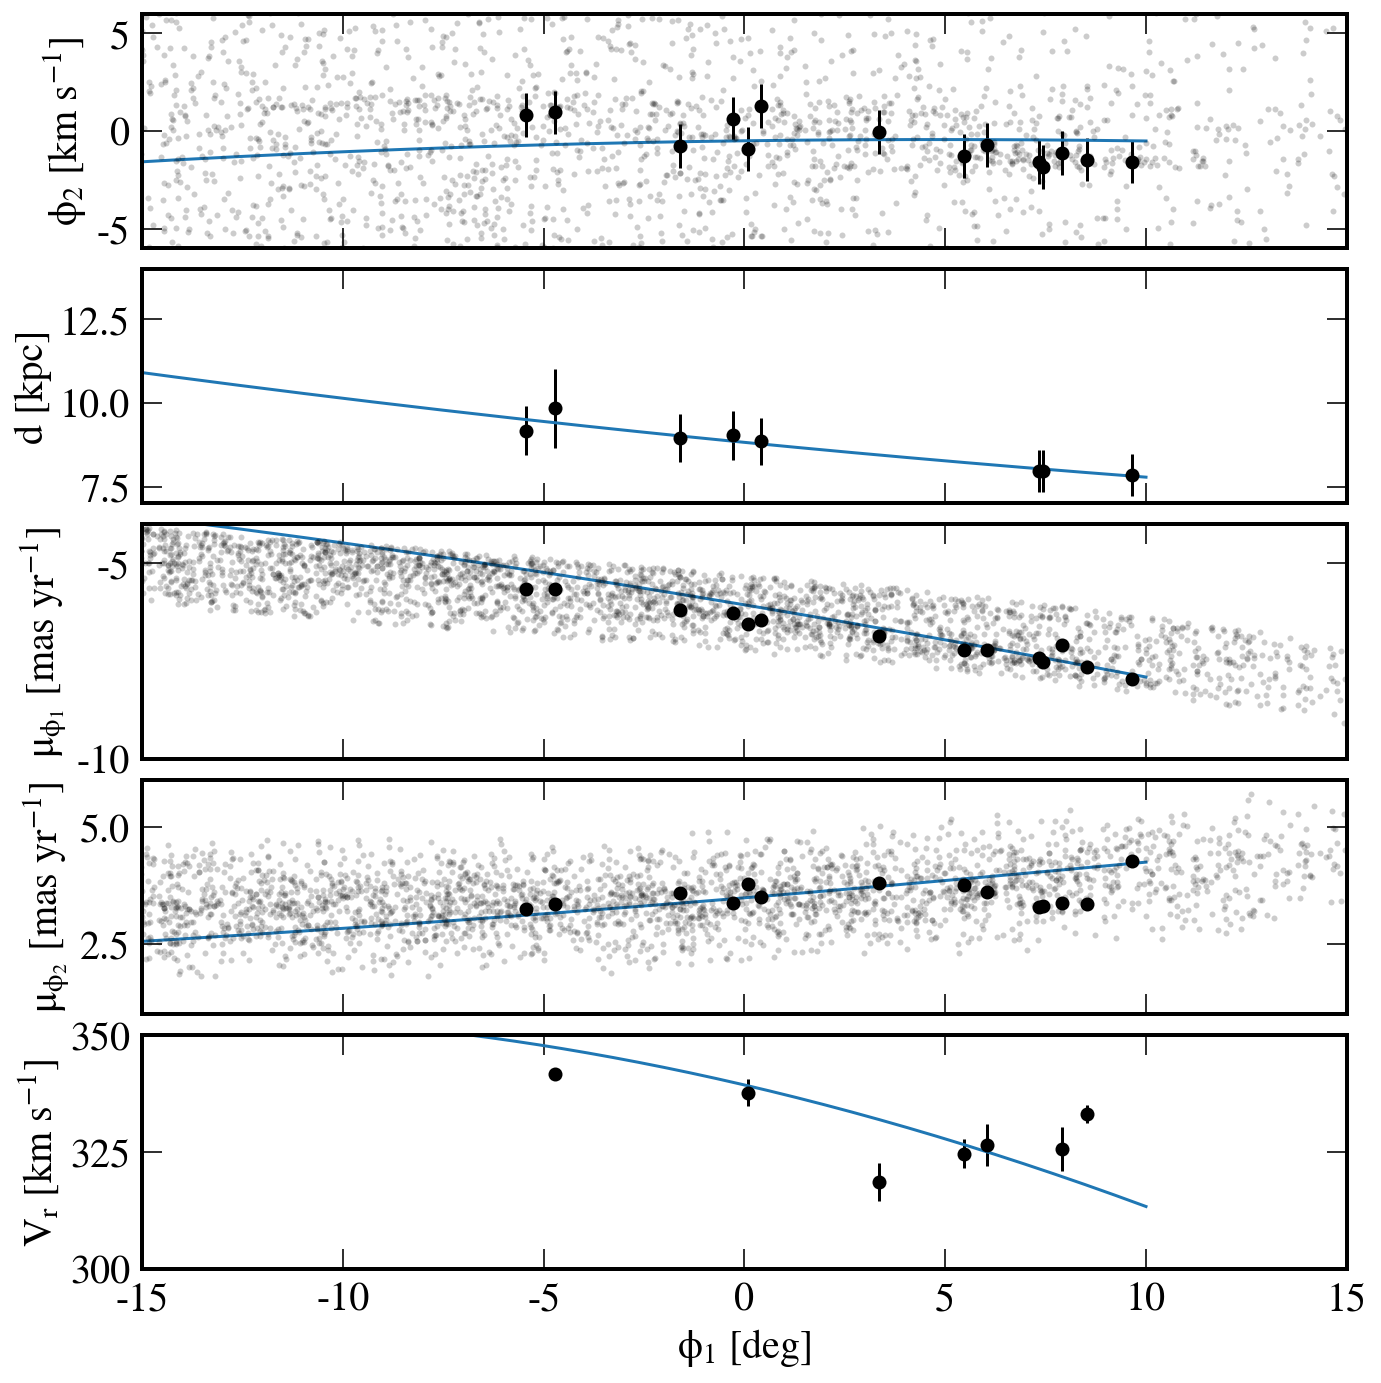

In [45]:
phi1 = x0
phi2, d, pm1, pm2, vr = pbest
    
c = coord.SkyCoord(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, pm_phi1_cosphi2=pm1*u.mas/u.yr, 
                       pm_phi2=pm2*u.mas/u.yr, radial_velocity=vr*u.km/u.s, frame=fr)

# integrate orbit
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)

# project stream coordinates
model_stream = orbit.to_coord_frame(fr, galactocentric_frame=gc_frame)

ylabels = ['$\phi_2$ [km s$^{-1}$]', 'd [kpc]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
          '$V_r$ [km s$^{-1}$]']

ylims = [[-6,6], [7,14], [-10,-4], [1,6], [300,350]]

ymodel = [model_stream.phi2, model_stream.distance, model_stream.pm_phi1_cosphi2, model_stream.pm_phi2,
         model_stream.radial_velocity]

fig, ax = plt.subplots(5,1,figsize=(10,10), sharex=True)

for i, k in enumerate(data.keys()):
    plt.sca(ax[i])
    plt.errorbar(data[k][0], data[k][1], yerr=data[k][2], fmt='o', color='k')
    plt.plot(model_stream.phi1, ymodel[i], '-')
    
    plt.ylabel(ylabels[i])
    plt.ylim(ylims[i])
plt.xlim(-15,15)
plt.xlabel('$\phi_1$ [deg]')

plt.sca(ax[0])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.sca(ax[2])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi1_cosphi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.sca(ax[3])
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_nc_dbhb.pm_phi2[ind_cmd & ind_pm], 'ko', ms=3, mew=0, alpha=0.2)

plt.tight_layout(h_pad=0)

In [46]:
print(orbit.energy()[0], orbit.angular_momentum()[:,0])

-0.11217091189273753 kpc2 / Myr2 [1.02373046 0.85959403 2.42808497] kpc2 / Myr


## Mock stream

In [47]:
# progenitor position
ind_prog = np.argmin(np.abs(model_stream.phi1))
c_prog = model_stream[ind_prog]
w0_prog = gd.PhaseSpacePosition(c_prog.transform_to(gc_frame).cartesian)

In [48]:
# setup mockstream generator
df = ms.FardalStreamDF()
prog_mass = 1e4*u.Msun

gen = ms.MockStreamGenerator(df, ham)

In [49]:
stream, prog = gen.run(w0_prog, prog_mass, dt=-1*u.Myr, n_steps=1000)

In [50]:
stream_fr = stream.to_coord_frame(fr, galactocentric_frame=gc_frame)

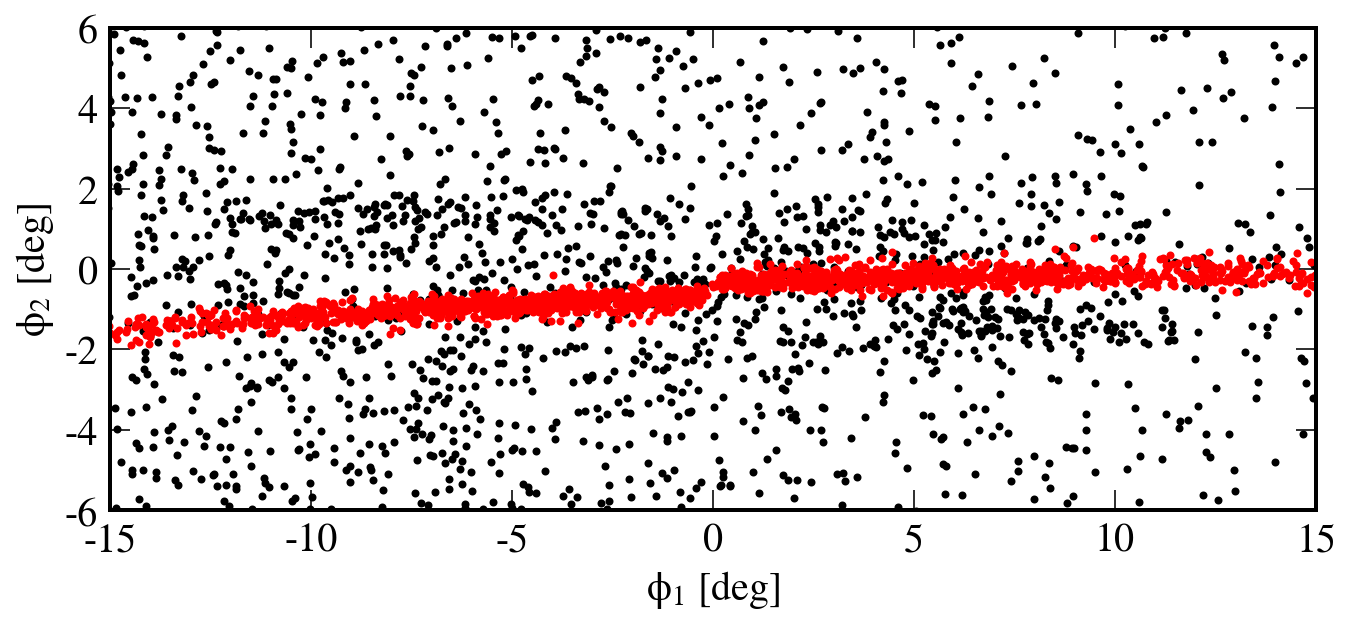

In [51]:
plt.figure(figsize=(10,5))
plt.plot(c_dbhb.phi1[ind_cmd & ind_pm], c_dbhb.phi2[ind_cmd & ind_pm], 'ko', ms=3)
plt.plot(stream_fr.phi1, stream_fr.phi2, 'r.')

plt.xlim(-15,15)
plt.ylim(-6,6)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()